## Figure 5 - JUMP application

We attempt to integrate the JUMP dataset in with MitoCheck.
We quickly realize this is a super challenging task, and determine strategies to overcome challenges.

- Panel A: JUMP + MitoCheck UMAP
- Panel B: JUMP + MitoCheck UMAP with only AreaShape features
- 

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

# Load variables important for plotting (e.g., themes, phenotypes, etc.)
source("themes.r")

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘patchwork’ was built under R version 4.2.3”


In [2]:
# Set paths to load UMAP coordinates
# Loaded from: https://github.com/WayScience/JUMP-single-cell/tree/main/3.analyze_data/UMAP_analysis/results/Mito_JUMP_areashape_features
repo <- "https://github.com/WayScience/JUMP-single-cell"
commit_hash <- "d95bcc99cb99fe9093bf0d73e2019edeb1e57e87"
umap_file_path <- "3.analyze_data/UMAP_analysis/results/"

all_feature_umap_file <- "Mito_JUMP_all_features/Mito_JUMP_all_features_final_greg_areashape_model.tsv"
area_shape_umap_file <- "Mito_JUMP_areashape_features/Mito_JUMP_areashape_features_final_all_features_model.tsv"

all_feature_umap <- paste(repo, "raw", commit_hash, umap_file_path, all_feature_umap_file, sep = "/")
area_shape_umap <- paste(repo, "raw", commit_hash, umap_file_path, area_shape_umap_file, sep = "/")

In [3]:
# Load UMAP coordinates
all_feature_umap_df <- readr::read_tsv(
    all_feature_umap,
    col_types = readr::cols(
        .default = "d",
        Metadata_data_name = "c",
        Metadata_Predicted_Class = "c"
    )
)

area_shape_umap_df <- readr::read_tsv(
    area_shape_umap,
    col_types = readr::cols(
        .default = "d",
        Metadata_data_name = "c",
        Metadata_Predicted_Class = "c"
    )
)

print(dim(area_shape_umap_df))
head(area_shape_umap_df)

[1] 53916     5


Metadata_data_name,Metadata_Predicted_Class,Metadata_Phenotypic_Value,UMAP0,UMAP1
<chr>,<chr>,<dbl>,<dbl>,<dbl>
mitocheck,Large,1,1.97279210,6.335934
mitocheck,Large,1,3.21187040,5.616934
mitocheck,Large,1,-0.42430085,8.314137
mitocheck,Large,1,-0.07658324,10.818566
mitocheck,Large,1,2.21196080,6.890884
mitocheck,Large,1,3.82852080,5.996650


## Visualize UMAP coordinate integration JUMP into MitoCheck

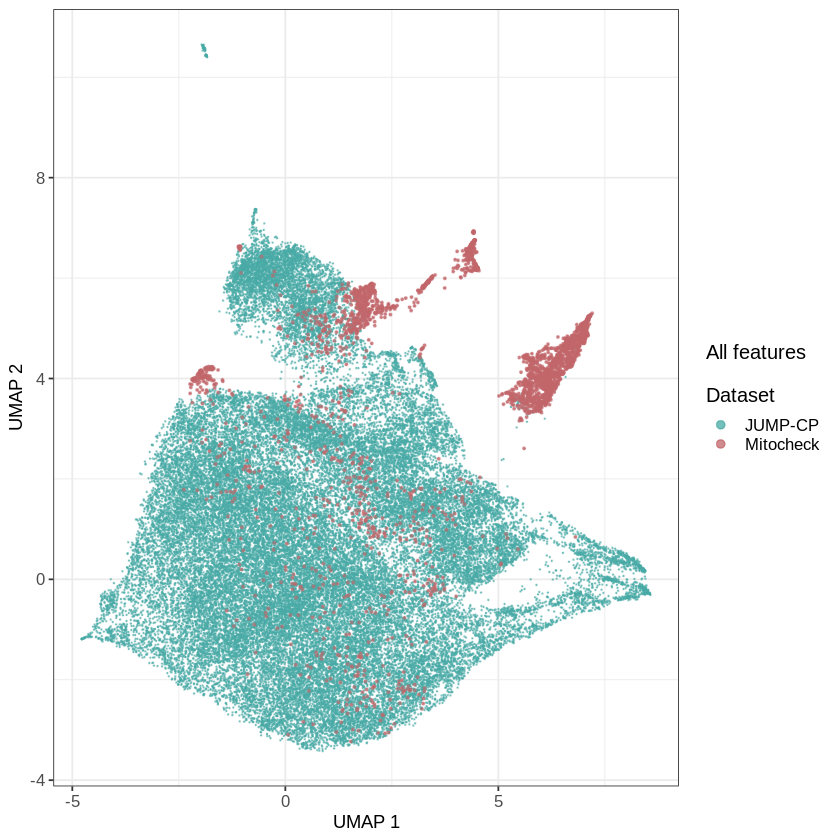

In [4]:
all_feature_umap_gg <- (
    ggplot(all_feature_umap_df, aes(x = UMAP0, y = UMAP1))
    + geom_point(
        aes(color = Metadata_data_name),
        size = 0.1,
        alpha = 0.5
    )
    + geom_point(
        data = all_feature_umap_df %>% dplyr::filter(Metadata_data_name == "mitocheck"),
        aes(color = Metadata_data_name),
        size = 0.5,
        alpha = 0.5
    )
    + theme_bw()
    + phenotypic_ggplot_theme
    + guides(
        color = guide_legend(
            override.aes = list(size = 2)
        )
    )
    + labs(x = "UMAP 1", y = "UMAP 2")
    + scale_color_manual(
        "All features\n\nDataset",
        values = dataset_colors,
        labels = dataset_labels
    )
)

all_feature_umap_gg

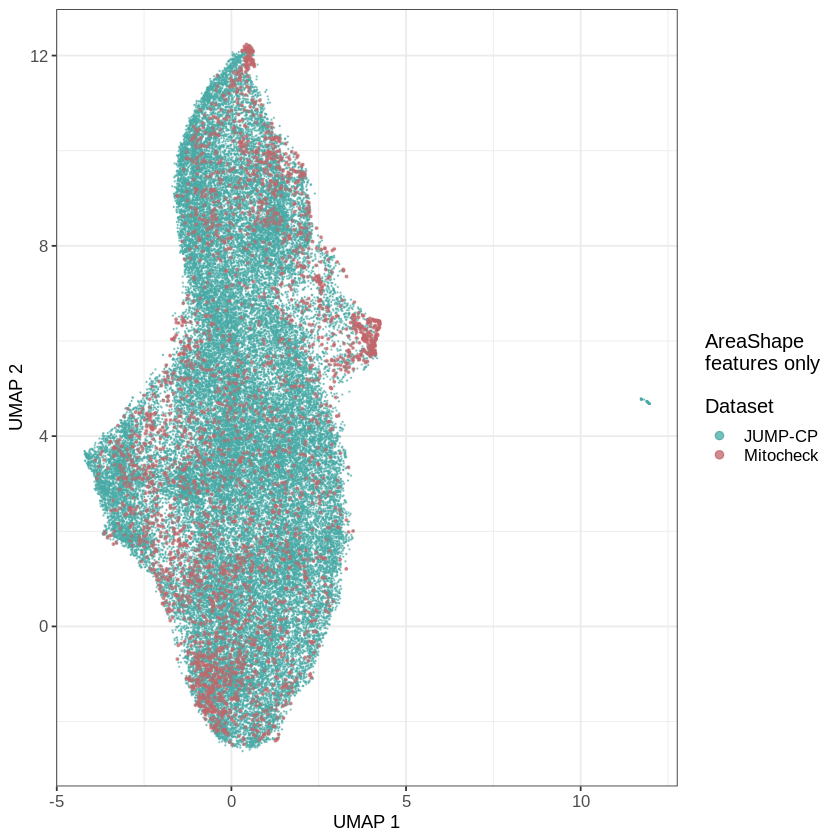

In [5]:
area_shape_umap_gg <- (
    ggplot(area_shape_umap_df, aes(x = UMAP0, y = UMAP1))
    + geom_point(
        aes(color = Metadata_data_name),
        size = 0.07,
        alpha = 0.5
    )
    + geom_point(
        data = area_shape_umap_df %>% dplyr::filter(Metadata_data_name == "mitocheck"),
        aes(color = Metadata_data_name),
        size = 0.5,
        alpha = 0.5
    )
    + theme_bw()
    + phenotypic_ggplot_theme
    + guides(
        color = guide_legend(
            override.aes = list(size = 2)
        )
    )
    + labs(x = "UMAP 1", y = "UMAP 2")
    + scale_color_manual(
        "AreaShape\nfeatures only\n\nDataset",
        values = dataset_colors,
        labels = dataset_labels
    )
) 

area_shape_umap_gg